In [3]:
from math import log
import numpy as np

# beam search
def beam_search_decoder(data, k):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence

    max_T, max_A = data.shape

    # Loop over time
    for t in range(max_T):
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            # Loop over possible alphabet outputs
            for c in range(max_A):
                candidate = [seq + [c], score - log(data[t, c])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

# define a sequence of 10 words (rows) over a vocab of 5 words (columns), 
# e.g.
#      a  bites cat  dog  the
# 1   0.1  0.2  0.3  0.4  0.5
# 2   0.5  0.3  0.5  0.2  0.1
# ...
# 10  0.3  0.4  0.5  0.2  0.1 

data = [[0.1, 0.2, 0.3, 0.4, 0.5],
        [0.4, 0.3, 0.5, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.5, 0.4, 0.3, 0.2, 0.1],
        [0.1, 0.2, 0.3, 0.4, 0.5],
        [0.3, 0.4, 0.5, 0.2, 0.1]]

data = np.array(data)

#beam_width = 1
#beam_width = 2
#beam_width = 3
#beam_width = 5
beam_width = 10
#beam_width = 100

# decode sequence
#result = beam_search_decoder(data, beam_width)
# print result
# for i, seq in enumerate(result):
#    print(i, seq)

##### decoding output.json
### element in data -> sequence over words -> element in logits

import json

f = json.load(open("output.json"))
alphabet = f["alphabet"]
data2 = f["logits"]
data2 = np.array(data2)
#print(data2[0])

# # decode sequence
result2 = beam_search_decoder(data2, beam_width)
# # print result
#print(result2)
#for i, seq in enumerate(result2):
#   print(i, seq)

#print('Res:')
#print(result2[len(result2)-1][0])
output_res = result2[len(result2)-1][0]


collapsed_res = []
temp_ch = 0
for ch in output_res:
    if temp_ch != ch:
        temp_ch = ch
        collapsed_res.append(temp_ch)
    
#print(collapsed_res)

output_string = ""
for letter in collapsed_res:
    output_string += alphabet[letter]

print('Decoded message with beam width: ' + str(beam_width))
print(output_string)

Decoded message with beam width: 10
we mustsois find a newoe tholme in the stsar os


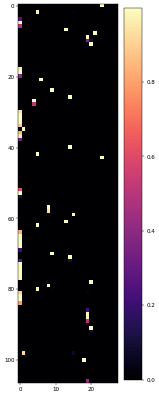

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(4, 40), dpi=40)

plt.imshow(data2, cmap='magma')
plt.colorbar()
plt.show()

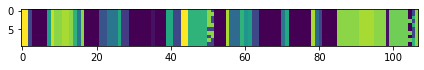

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

result_X = np.array([x[0] for x in result2])

fig, ax = plt.subplots()
im = ax.imshow(result_X)

fig.tight_layout()
plt.show()

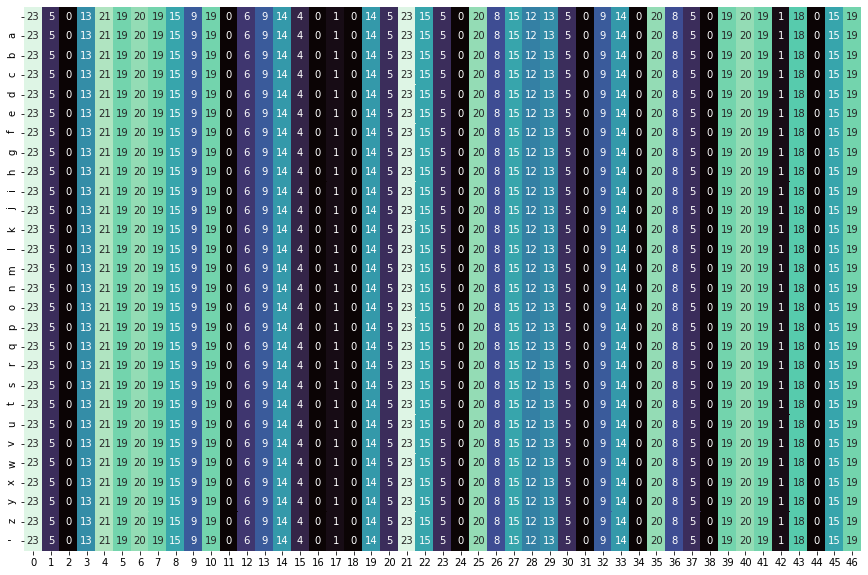

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

resX = [collapsed_res for x in range(28)]

plt.figure(figsize=(15, 10))
sns.heatmap(resX, annot=True, cbar=False, cmap="mako")
plt.yticks(np.arange(len(alphabet))+0.5, alphabet);

In [23]:
"""
Author: Awni Hannun

This is an example CTC decoder written in Python. The code is
intended to be a simple example and is not designed to be
especially efficient.

The algorithm is a prefix beam search for a model trained
with the CTC loss function.

For more details checkout either of these references:
  https://distill.pub/2017/ctc/#inference
  https://arxiv.org/abs/1408.2873

"""

import numpy as np
import math
import collections

NEG_INF = -float("inf")

def make_new_beam():
    fn = lambda : (NEG_INF, NEG_INF)
    return collections.defaultdict(fn)

def logsumexp(*args):
    """
    Stable log sum exp.
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max)
                      for a in args))
    return a_max + lsp

def decode(probs, beam_size=100, blank=0):
    """
    Performs inference for the given output probabilities.

    Arguments:
      probs: The output probabilities (e.g. post-softmax) for each
        time step. Should be an array of shape (time x output dim).
      beam_size (int): Size of the beam to use during inference.
      blank (int): Index of the CTC blank label.

    Returns the output label sequence and the corresponding negative
    log-likelihood estimated by the decoder.
    """
    T, S = probs.shape
    probs = np.log(probs)

    # Elements in the beam are (prefix, (p_blank, p_no_blank))
    # Initialize the beam with the empty sequence, a probability of
    # 1 for ending in blank and zero for ending in non-blank
    # (in log space).
    beam = [(tuple(), (0.0, NEG_INF))]

    for t in range(T): # Loop over time

        # A default dictionary to store the next step candidates.
        next_beam = make_new_beam()

        for s in range(S): # Loop over vocab
            p = probs[t, s]

          # The variables p_b and p_nb are respectively the
          # probabilities for the prefix given that it ends in a
          # blank and does not end in a blank at this time step.
            for prefix, (p_b, p_nb) in beam: # Loop over beam

                # If we propose a blank the prefix doesn't change.
                # Only the probability of ending in blank gets updated.
                if s == blank:
                    n_p_b, n_p_nb = next_beam[prefix]
                    n_p_b = logsumexp(n_p_b, p_b + p, p_nb + p)
                    next_beam[prefix] = (n_p_b, n_p_nb)
                    continue

                # Extend the prefix by the new character s and add it to
                # the beam. Only the probability of not ending in blank
                # gets updated.
                end_t = prefix[-1] if prefix else None
                n_prefix = prefix + (s,)
                n_p_b, n_p_nb = next_beam[n_prefix]
                if s != end_t:
                    n_p_nb = logsumexp(n_p_nb, p_b + p, p_nb + p)
                else:
                  # We don't include the previous probability of not ending
                  # in blank (p_nb) if s is repeated at the end. The CTC
                  # algorithm merges characters not separated by a blank.
                    n_p_nb = logsumexp(n_p_nb, p_b + p)

                # *NB* this would be a good place to include an LM score.
                next_beam[n_prefix] = (n_p_b, n_p_nb)

                # If s is repeated at the end we also update the unchanged
                # prefix. This is the merging case.
                if s == end_t:
                    n_p_b, n_p_nb = next_beam[prefix]
                    n_p_nb = logsumexp(n_p_nb, p_nb + p)
                    next_beam[prefix] = (n_p_b, n_p_nb)

    # Sort and trim the beam before moving on to the
    # next time-step.
    beam = sorted(next_beam.items(),
            key=lambda x : logsumexp(*x[1]),
            reverse=True)
    beam = beam[:beam_size]

    best = beam[0]
    return best[0], -logsumexp(*best[1])

if __name__ == "__main__":
    np.random.seed(3)

    #time = len(data2) #timestamp -> len(data2)
    #output_dim = len(alphabet) #-> len(alphabet)

    probs = data2
    probs = probs / np.sum(probs, axis=1, keepdims=True)

    labels, score = decode(probs)
    print("Score {:.3f}".format(score))

Score 0.006
